# Image Captioning NN

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week06/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

Steps to train the model:
* Take a pre-trained inception v3 to vectorize images
* Stack an LSTM on top of it
* Train the thing on MSCOCO

In [14]:
# ! apt update && install wget -y

In [15]:
import os
import json
from random import choice
from collections import defaultdict, Counter
from textwrap import wrap

import numpy as np
import matplotlib.pyplot as plt

import mlflow

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from skimage.transform import resize

from tqdm import tqdm_notebook, tqdm
from IPython.display import clear_output

from ml_models.beheaded_inception3 import beheaded_inception_v3

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
# # download training data
# os.system('wget -qO- https://github.com/hse-aml/intro-to-dl-pytorch/releases/download/final_project/handout.tar.gz | tar -xzvf - -C .')
# os.system('mv data/image_codes.npy ml_data')
# os.system('mkdir ml_data/test_images')
# for i in range(30):
#     os.system(f'wget -q https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/week06/data/img_{i}.jpg -O ml_data/test_images/{i}.jpg')
# os.system('rm -rf data')

In [10]:
# load dataset (vectorized images and captions)
img_codes = np.load("ml_data/image_codes.npy")
captions = json.load(open('ml_data/captions_tokenized.json'))

In [11]:
# split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

In [12]:
# build a vocabulary
from collections import Counter
word_counts = Counter()

for img in captions:
    for caption in img:
        word_counts.update(caption)

vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [12]:
# function for converting list of tokens into matrix

eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

## Model Architecture

<img src="https://github.com/yunjey/pytorch-tutorial/raw/master/tutorials/03-advanced/image_captioning/png/model.png" style="width:70%">

In [15]:
class CaptionNet(nn.Module):
    
    def __init__(self, n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()
        
        # a layer that converts conv features to initial_h (h_0) and initial_c (c_0)
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.embedding = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.rnn_to_logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """

        self.lstm.flatten_parameters()

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        emb_ix = self.embedding(captions_ix)
        
        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(emb_ix, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.rnn_to_logits(lstm_out)

        return logits

In [17]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last because we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    # compute the loss function between logits_for_next and captions_ix_next
    loss = F.cross_entropy(
        logits_for_next.permute((0,2,1)), 
        captions_ix_next, 
        ignore_index=pad_ix
    )

    return loss

In [21]:
def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    # sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    # get images
    batch_images = img_codes[random_image_ix]
    
    # 5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    # pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    # convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), \
        torch.tensor(batch_captions_ix, dtype=torch.int64)

In [42]:
def generate_caption(network, vectorizer, image, caption_prefix = ('#START#',), t=1, sample=True, max_len=100):
    network = network.cpu().eval()

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = vectorizer(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word == '#END#':
            break

    return ' '.join(caption_prefix[1:-1])

In [ ]:
# split dataset
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes, captions, test_size=0.1, random_state=42
)


Epoch: 30, train loss: 2.1653782327014666, val loss: 2.4023163759190105


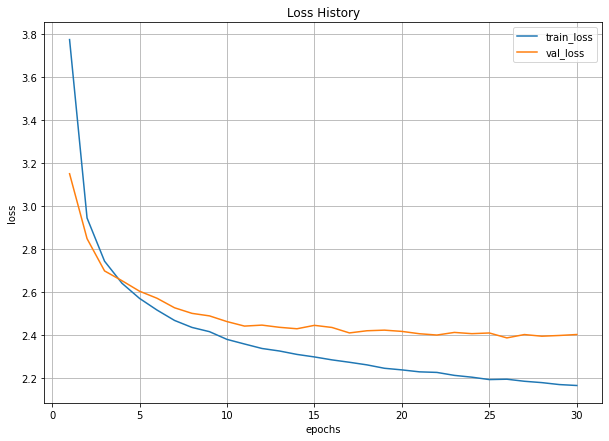

Finished!


In [30]:
# train model

history = defaultdict(list)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 30
batch_size = 128
learning_rate = 1e-3

network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

n_batches_per_epoch = round(train_img_codes.shape[0] / batch_size)
n_validation_batches = round(val_img_codes.shape[0] / batch_size)

for epoch in range(1, epochs + 1):
    
    train_loss = 0
    network.train()
    for _ in tqdm(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    history['train_loss'].append(train_loss)
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    history['val_loss'].append(val_loss)
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # plot loss history
    plt.figure(figsize=[10, 7])
    plt.plot(range(1, epoch + 1), history['train_loss'], label='train_loss')
    plt.plot(range(1, epoch + 1), history['val_loss'], label='val_loss')
    plt.title('Loss History')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

print("Finished!")

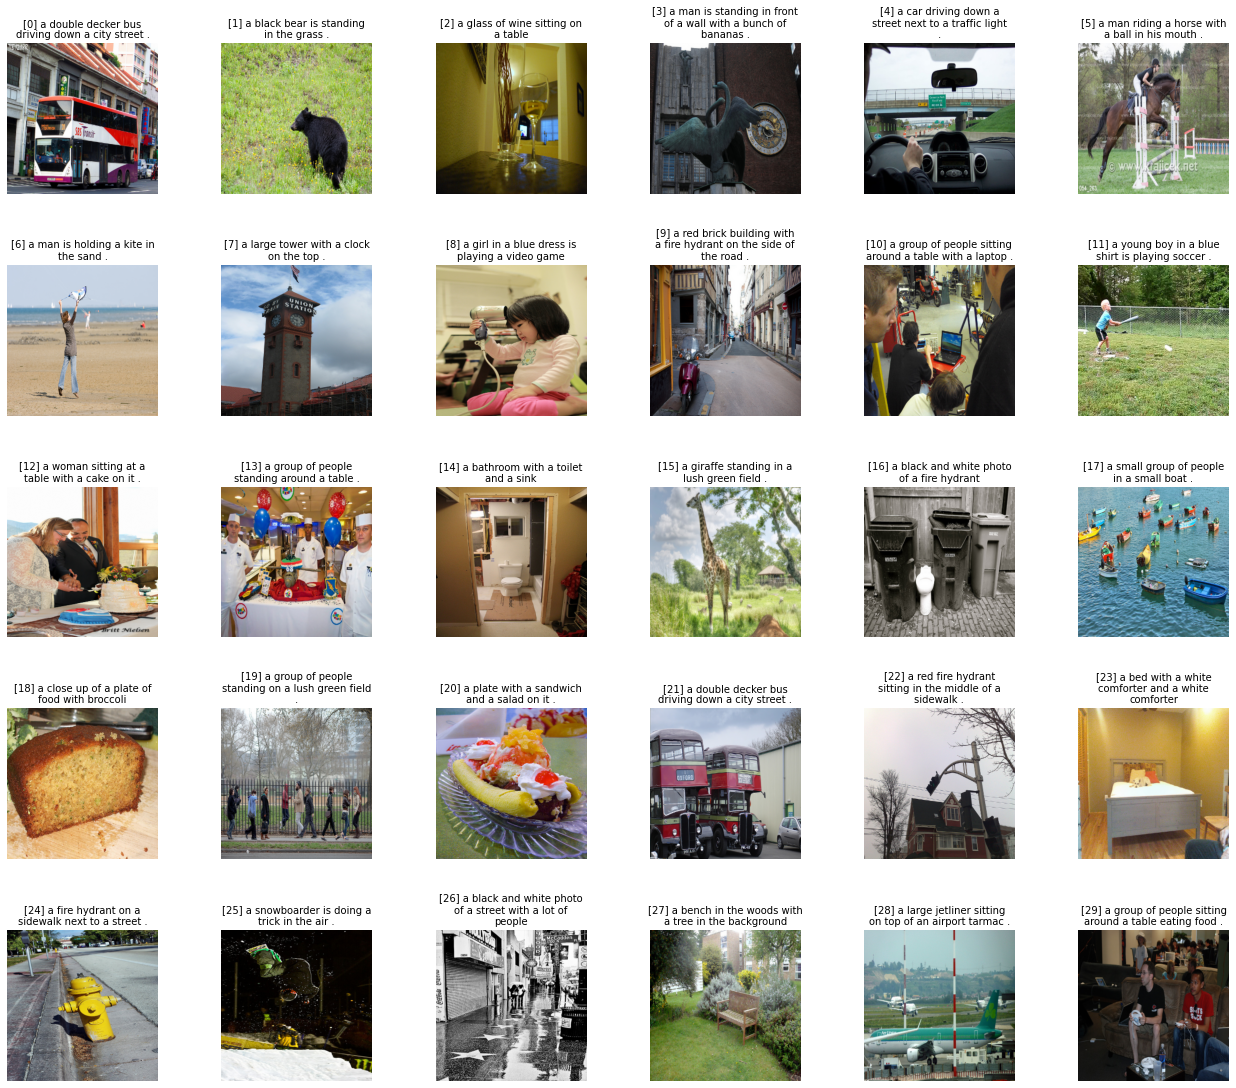

In [45]:
# test model performance visually on real images

# load vectorizer
vectorizer = beheaded_inception_v3().eval()

# load test images
test_images = []
for i in range(30):
    img = plt.imread(f'ml_data/test_images/{i}.jpg')
    img = resize(img, (299, 299))
    test_images.append(img)

# plot images with captions
fig, axes = plt.subplots(5, 6, figsize=[18, 15])
fig.tight_layout(h_pad=5)
for i in range(30):
    img = test_images[i]
    caption = generate_caption(network, vectorizer, img, t=5.)
    ax = axes[i//6][i%6]
    ax.imshow(img)
    ax.set_title("\n".join(wrap(f'[{i}] ' + caption, 30)), fontsize=10)
    ax.axis('off')

In [ ]:
# save training results to MLflow

# connect to server
mlflow_host = os.environ.get('MLFLOW_HOST') or 'localhost'
mlflow_port = os.environ.get('MLFLOW_PORT') or 5000
mlflow_url = f'http://{mlflow_host}:{mlflow_port}'
mlflow.set_tracking_uri(mlflow_url)

# run experiment
experiment_name = 'lsml2_demo'
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)
    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_metric('train_loss', train_loss)
    mlflow.log_metric('val_loss', val_loss)
    mlflow.pytorch.log_model(network, "model")